In [ ]:
import numpy as np
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((300,300))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        if 'good' in fname.split('\\'):
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths

def get_conv_model():
    
    input_img = keras.Input(train[0].shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    return autoencoder
      

path_train = r".\Data\bottle.tar\bottle\train\**\*.*"
path_test = r".\Data\bottle.tar\bottle\test\**\*.*"

all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)

all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
autoencoder=get_conv_model()
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
es_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
epochs=40
autoencoder_train=autoencoder.fit(train, train,
            epochs=epochs,
            batch_size=50,
            shuffle=False,
            validation_data=(test, test),
            callbacks=[es_callback])


Epoch 1/40
4/4 [==============================] - 51s 12s/step - loss: 0.1324 - mae: 0.3359 - val_loss: 0.1239 - val_mae: 0.3314
Epoch 2/40
4/4 [==============================] - 59s 14s/step - loss: 0.1208 - mae: 0.3331 - val_loss: 0.1127 - val_mae: 0.3236
Epoch 3/40
4/4 [==============================] - 56s 14s/step - loss: 0.1095 - mae: 0.3200 - val_loss: 0.0985 - val_mae: 0.3037
Epoch 4/40
4/4 [==============================] - 60s 15s/step - loss: 0.0948 - mae: 0.2969 - val_loss: 0.0826 - val_mae: 0.2667
Epoch 5/40
4/4 [==============================] - 62s 15s/step - loss: 0.0793 - mae: 0.2632 - val_loss: 0.0673 - val_mae: 0.2386
Epoch 6/40
4/4 [==============================] - 68s 17s/step - loss: 0.0671 - mae: 0.2312 - val_loss: 0.0582 - val_mae: 0.2174
Epoch 7/40
4/4 [==============================] - 72s 17s/step - loss: 0.0575 - mae: 0.2068 - val_loss: 0.0495 - val_mae: 0.1921
Epoch 8/40
4/4 [==============================] - 72s 17s/step - loss: 0.0497 - mae: 0.1842 - val

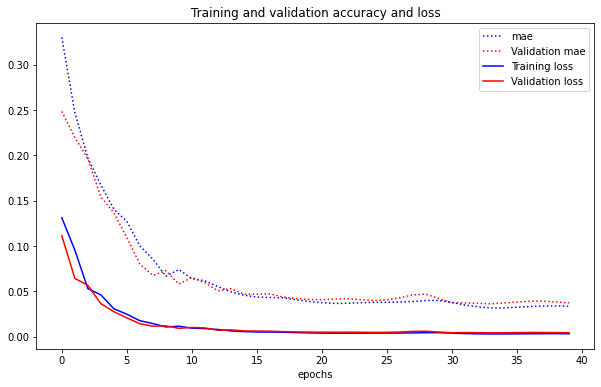

In [188]:
x=range(epochs)
loss = autoencoder_train.history['loss']
mae = autoencoder_train.history['mae']
val_mae = autoencoder_train.history['val_mae']
val_loss = autoencoder_train.history['val_loss']
plt.figure(figsize=(10,6))
plt.plot(x, mae, 'b:', label='mae')
plt.plot(x, val_mae, 'r:', label='Validation mae')
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy and loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


In [189]:

def get_error(imgs_true, imgs_pred):
    return np.mean(np.power(imgs_true - imgs_pred, 2))
          
train_pred = autoencoder.predict(train)
mse_vector=[]
mse_vector_test=[]
for i in range(train.shape[0]):
    mse_vector.append( get_error(train_pred[i], train[i]))

threshold = np.quantile(mse_vector, 0.99)

test_pred = autoencoder.predict(test)

for i in range(test.shape[0]):
    mse_vector_test.append( get_error(test_pred[i], test[i]))
test_anomaly = (mse_vector_test > threshold)



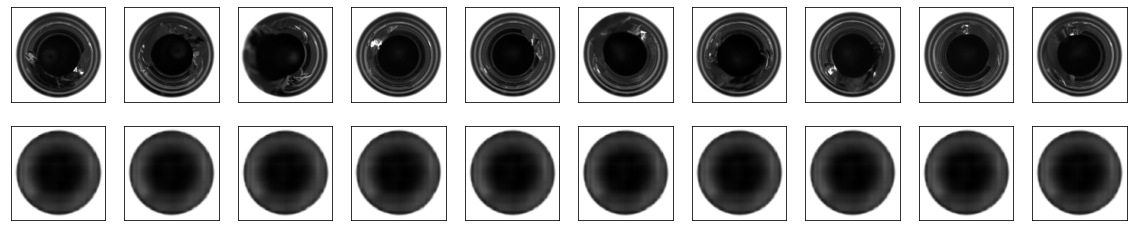

In [193]:

decoded_imgs = autoencoder.predict(test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test[i].reshape(300,300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(300,300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
